In [1]:
!git clone https://github.com/6862-2021SP-team3/pytorch-normalizing-flows.git

Cloning into 'pytorch-normalizing-flows'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 54 (delta 17), reused 38 (delta 8), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [2]:
#copy files from dropbox 
!wget -O pi0.pkl https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0

--2021-04-10 17:52:37--  https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hrdhr5o1khtclmy/pi0.pkl [following]
--2021-04-10 17:52:37--  https://www.dropbox.com/s/raw/hrdhr5o1khtclmy/pi0.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7db486b168574bc1cbdc306913.dl.dropboxusercontent.com/cd/0/inline/BMWSOgrQE8jNYnOIfCFXUxeXw9VGX8AN35LF12gfJDb3LxBFjPa_dswhfQrfj2-2OD3EgmWF8MRacGUSrJIUUGQ_qFjjKpyeP2kvSUF4-GBNbAtQFQVF4zkZIUCh5t4GCtc4RQ1PEErCAf8UWV71PbF0/file# [following]
--2021-04-10 17:52:37--  https://uc7db486b168574bc1cbdc306913.dl.dropboxusercontent.com/cd/0/inline/BMWSOgrQE8jNYnOIfCFXUxeXw9VGX8AN35LF12gfJDb3LxBFjPa_dswhfQrfj2-2OD3EgmWF8MRacGUSrJIUUGQ_qFjjKpyeP2kv

In [3]:
#python 3.7 uses pickle4, use pickle5 to load dataset.
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 133kB 7.9MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219239 sha256=efdd679a7f9a10f629c0a2d1e5b40a5609203fad94a52a74234f49b62f0d5c58
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [4]:
import sys
sys.path.insert(0,'/content/pytorch-normalizing-flows')


In [5]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nflib.spline_flows import NSF_AR, NSF_CL

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [6]:
class dataXZ:
  """
  read the data stored in pickle format
  the converting routine is at https://github.com/6862-2021SP-team3/hipo2pickle
  """
  def __init__(self):
    with open('pi0.pkl', 'rb') as f:
        xz = np.array(pickle.load(f), dtype=np.float32)
        xz = xz[:, 1:]
        x = xz[:, :16]
        z = xz[:, 16:]
        xwithoutPid = x[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        zwithoutPid = z[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        self.xz = xz
        self.x = torch.from_numpy(np.array(x))
        self.z = torch.from_numpy(np.array(z))
        self.xwithoutPid = torch.from_numpy(xwithoutPid)
        self.zwithoutPid = torch.from_numpy(zwithoutPid)

  def sample(self, n):
        randint = np.random.randint( self.xz.shape[0], size =n)
        xz = self.xz[randint]
        x = self.x[randint]
        z = self.z[randint]
        xwithoutPid = self.xwithoutPid[randint]
        zwithoutPid = self.zwithoutPid[randint]
        return {"xz":xz, "x": x, "z": z, "xwithoutPid": xwithoutPid, "zwithoutPid": zwithoutPid}

In [7]:
xz = dataXZ()
z = xz.z
x = xz.x

In [ ]:
sampleDict = xz.sample(100)
print(sampleDict["xz"][0])
print(sampleDict["xwithoutPid"][0])

[   5.1623626    15.133389     51.502148      1.            0.62391466
   18.860155     84.42612       2.            4.644195     16.498932
 -124.434235      3.            0.54434437   21.61841    -123.087654
    3.            5.1850605    15.079152     51.689957      1.
    0.631484     18.432833     85.10803       2.            4.6959305
   16.42999    -124.321884      3.            0.5249474    21.33697
 -123.03439       3.        ]
tensor([   5.1624,   15.1334,   51.5021,    0.6239,   18.8602,   84.4261,
           4.6442,   16.4989, -124.4342,    0.5443,   21.6184, -123.0877])


In [76]:
# construct a model
# try with electron momentum magintude and polar angle only
#prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution

# RealNVP
# flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]

# NICE
flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(8)]
flows.append(AffineConstantFlow(dim=2, shift=False))

# SlowMAF (MAF, but without any parameter sharing for each dimension's scale/shift)
# flows = [SlowMAF(dim=2, parity=i%2) for i in range(4)]

# MAF (with MADE net, so we get very fast density estimation)
# flows = [MAF(dim=2, parity=i%2) for i in range(4)]

# IAF (with MADE net, so we get very fast sampling)
# flows = [IAF(dim=2, parity=i%2) for i in range(3)]

# insert ActNorms to any of the flows above
# norms = [ActNorm(dim=2) for _ in flows]
# flows = list(itertools.chain(*zip(norms, flows)))

# Glow paper
# flows = [Invertible1x1Conv(dim=2) for i in range(3)]
# norms = [ActNorm(dim=2) for _ in flows]
# couplings = [AffineHalfFlow(dim=2, parity=i%2, nh=32) for i in range(len(flows))]
# flows = list(itertools.chain(*zip(norms, flows, couplings))) # append a coupling layer after each 1x1

# Neural splines, coupling
# nfs_flow = NSF_CL if True else NSF_AR
# flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(3)]
# convs = [Invertible1x1Conv(dim=2) for _ in flows]
# norms = [ActNorm(dim=2) for _ in flows]
# flows = list(itertools.chain(*zip(norms, convs, flows)))

# construct the model
model = NormalizingFlowModel(prior, flows)

In [77]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  10186


In [78]:
model.train()
for k in range(1000):
    sampleDict = xz.sample(10000)
    x = sampleDict["xwithoutPid"][:, 0:2] # try with electron momentum magintude and polar angle only.
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())


200848.453125
124958.53125
115429.90625
99916.71875
92895.46875
85813.6171875
71688.078125
52353.109375
40519.7109375
34000.171875


tensor([ 2.6603, 22.8065])


Text(0.5, 1.0, 'z -> x')

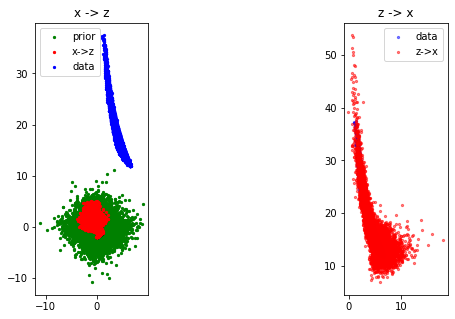

In [79]:
model.eval()

sampleDict = xz.sample(10000)
x = sampleDict["xwithoutPid"][:, 0:2]
print(x[0])
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([10000, 2]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

zs = model.sample(10000)
z = zs[-1]
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

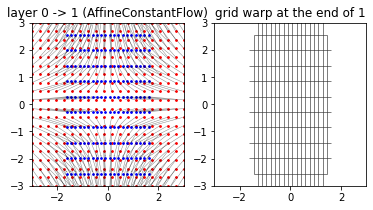

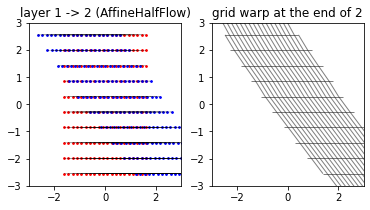

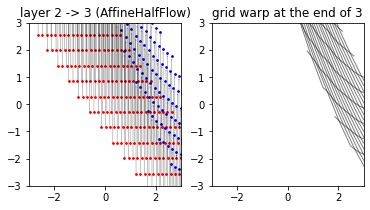

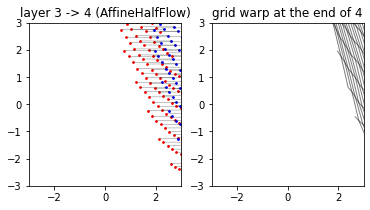

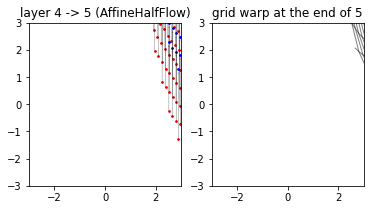

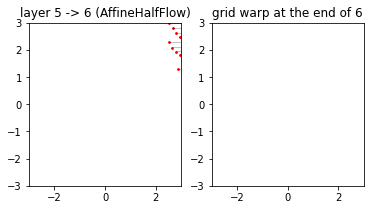

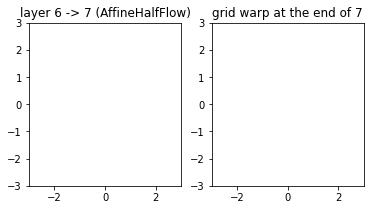

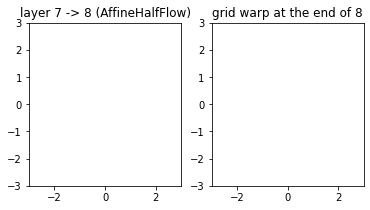

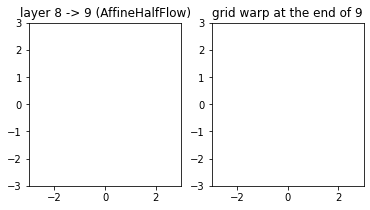

In [80]:
# Visualize the step-wise flow in the full net
from matplotlib import collections  as mc

# plot the coordinate warp
ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3 # seems appropriate since we use radial distributions as priors
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

zs, log_det = model.backward(xy)

backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
nz = len(zs)
for i in range(nz - 1):
    z0 = zs[i].detach().numpy()
    z1 = zs[i+1].detach().numpy()
    
    # plot how the samples travel at this stage
    figs, axs = plt.subplots(1, 2, figsize=(6, 3))
    #plt.figure(figsize=(20,10))
    axs[0].scatter(z0[:,0], z0[:, 1], c='r', s=3)
    axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=3)
    axs[0].quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
    axs[0].axis([-3, 3, -3, 3])
    axs[0].set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
    
    q = z1.reshape((ng, ng, 2))
    # y coords
    p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # x coords
    p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # draw the lines
    axs[1].add_collection(lcy)
    axs[1].add_collection(lcx)
    axs[1].axis([-3, 3, -3, 3])
    axs[1].set_title("grid warp at the end of %d" % (i+1,))
    
    # draw the data too
    plt.scatter(x[:,0], x[:,1], c='r', s=5, alpha=0.5)
    


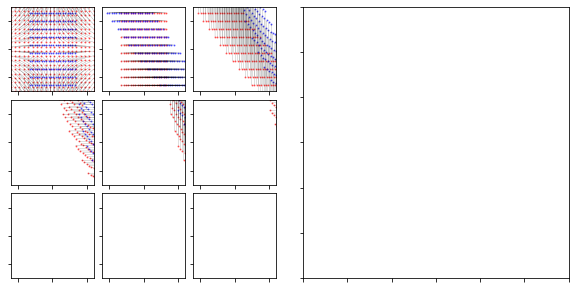

In [81]:

# train and render
# code duplication because it's very late at night now and i'm tired

import matplotlib.gridspec as gridspec

ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

# xval = d.sample(128*5)
sampleDict = xz.sample(128*5)
xval = sampleDict["xwithoutPid"][:, 0:2]

model.train()
for k in range(500):
    
    # sample
    # x = d.sample(128)
    sampleDict = xz.sample(128)
    x = sampleDict["xwithoutPid"][:, 0:2]

    # train a bit
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL
    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    if k % 10 == 0:
        # vis
        zs, log_det = model.backward(xy)
        backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
        nz = len(zs)
        i = nz - 1 - 1

        z0 = zs[i].detach().numpy()
        z1 = zs[i+1].detach().numpy()

        # plot how the samples travel at this stage
        ss = 0.1
        fig = plt.figure(figsize=(10, 5))
        outer = gridspec.GridSpec(1, 2, wspace=ss, hspace=ss)
        inner1 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=outer[0], wspace=ss, hspace=ss)
        inner2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], wspace=ss, hspace=ss)
        
        backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
        nz = len(zs)
        for i in range(min(nz-1, 9)):
            ax = plt.Subplot(fig, inner1[i])
            z0 = zs[i].detach().numpy()
            z1 = zs[i+1].detach().numpy()
            ax.scatter(z0[:,0], z0[:, 1], c='r', s=1, alpha=0.5)
            ax.scatter(z1[:,0], z1[:, 1], c='b', s=1, alpha=0.5)
            ax.quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
            ax.axis([-3, 3, -3, 3])
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            #ax.set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
            fig.add_subplot(ax)
        
        ax = plt.Subplot(fig, inner2[0])
        q = z1.reshape((ng, ng, 2))
        # y coords
        p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
        p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        # x coords
        p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
        p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        # draw the lines
        ax.add_collection(lcy)
        ax.add_collection(lcx)
        ax.axis([-3, 3, -3, 3])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        #ax.set_title("grid warp at the end of %d" % (i+1,))
        fig.add_subplot(ax)
        
        # draw the data too
        plt.scatter(xval[:,0], xval[:,1], c='r', s=5, alpha=0.5)
        
        break
        #fname = 'out/step_%04d.png' % (k,)
        #plt.savefig(fname, dpi=200)
        #print("saved", fname, 'loss', loss.item())
        #plt.close(fig)
        